## Intro 

### Tree SHAP  - advantages / disadvantages
KernelSHAP ignores feature dependence. Most other permutation based interpretation methods have this problem. By replacing feature values with values from random instances, it is usually easier to randomly sample from the marginal distribution. However, if features are dependent, e.g. correlated, this leads to putting too much weight on unlikely data points. TreeSHAP solves this problem by explicitly modeling the conditional expected prediction.
TreeSHAP can produce unintuitive feature attributions. While TreeSHAP solves the problem of extrapolating to unlikely data points, it does so by changing the value function and therefore slightly changes the game. TreeSHAP changes the value function by relying on the conditional expected prediction. With the change in the value function, features that have no influence on the prediction can get a TreeSHAP value different from zero.
The disadvantages of Shapley values also apply to SHAP: Shapley values can be misinterpreted and access to data is needed to compute them for new data (except for TreeSHAP).

https://christophm.github.io/interpretable-ml-book/shap.html#disadvantages-17


#### LightGBM SHAP
LightGBM can predict contributions: If you want to get more explanations for your model’s predictions using SHAP values, like SHAP interaction values, you can install the shap package (https://github.com/slundberg/shap). Note that unlike the shap package, with pred_contrib we return a matrix with an extra column, where the last column is the expected value.
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor.predict

In [10]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\Matty\AppData\Local\Temp\ipykernel_57708\340966624.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_exog = pd.concat([df_exog, df_exog_brand])


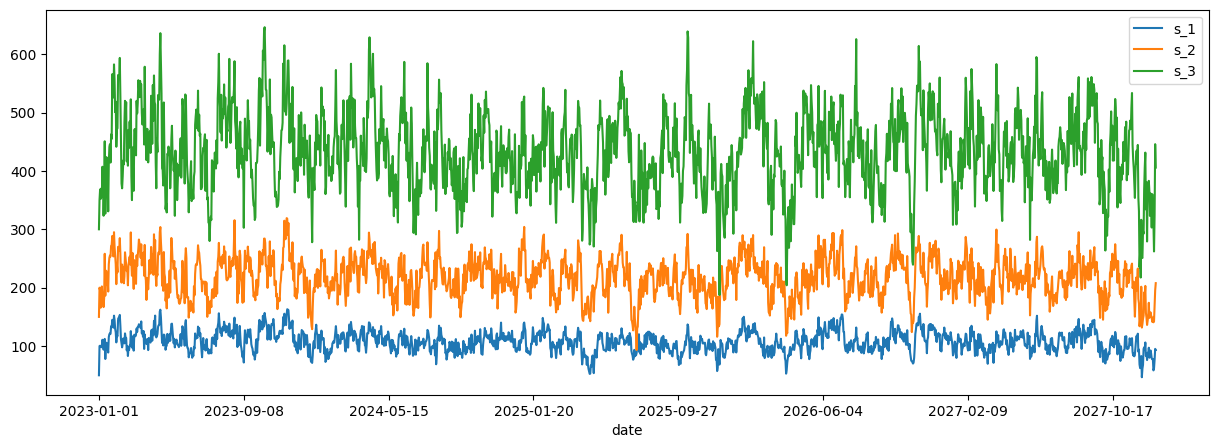

In [31]:
import pandas as pd

df = pd.read_csv("data/linear_dep_time_series.csv")
series = ["s_1", "s_2", "s_3"]
df.set_index("date")[series].plot(figsize=(15, 5))
df.head()

df["date"] = pd.to_datetime(df["date"])
df["holiday"] = df["holiday"].astype(bool)

# df.info()

# melt the series and prepare for the model

df_demand = df.melt(
    id_vars=["date"], value_vars=series, var_name="series_id", value_name="value"
)

# create exog dataframe for holiday and	weather
df_exog_temp = df[["date", "holiday", "weather"]].drop_duplicates()

#replicate the exog data for each series and set the series_id
df_exog = pd.DataFrame(columns=df_exog_temp.columns)
df_exog["series_id"] = ""
for brand in series:
    df_exog_brand = df_exog_temp.copy()
    df_exog_brand["series_id"] = brand
    df_exog = pd.concat([df_exog, df_exog_brand])


## Dataset

Dataset dates      : (Timestamp('2023-01-01 00:00:00'), Timestamp('2027-12-30 00:00:00'))  (n=1825)
Train dates      : (Timestamp('2023-01-01 00:00:00'), Timestamp('2026-12-31 00:00:00'))  (n=1461)
Test dates      : (Timestamp('2026-12-31 00:00:00'), Timestamp('2027-12-30 00:00:00'))  (n=365)


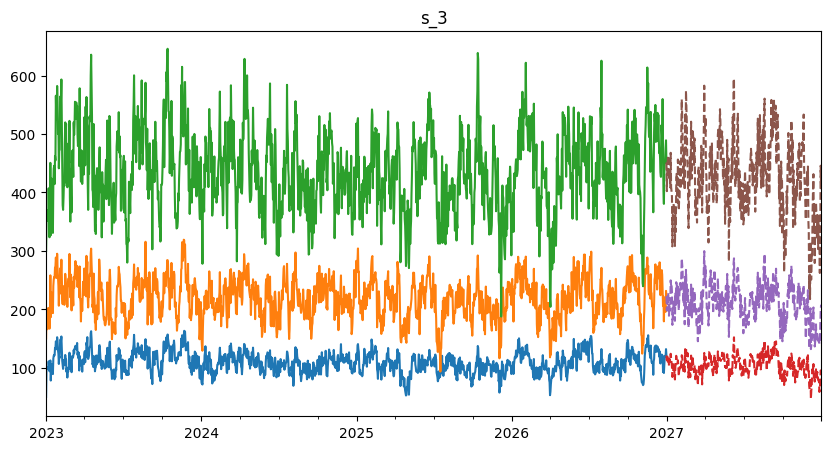

In [32]:
from tsxp.dataset import ForecasterMsDataset, DatasetMapping
from tsxp.forecaster import ForecasterMsExog
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection  import TimeSeriesFold

# define split date
split_date = "2026-12-31"



mapping = DatasetMapping(
    freq="D",
    index="date",
    series_id="series_id",
    series_value="value",
)

dataset = ForecasterMsDataset(df_demand, df_exog, mapping, split_time=split_date)

dataset.show_sizes()
dataset.plot_series()


In [ ]:


def search_space(trial):
    return {
        "lags": trial.suggest_categorical("lags", [4, [1, 2, 4, 5]]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
        # "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 2, 20),
    }


regressor = LGBMRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster = ForecasterMsExog( 
    data = dataset,
    regressor=regressor,
    scale=scaler
    # search_space=search_space,
)
forecaster.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  



  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 0.507296
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_

(            levels          lags  \
 0  [s_1, s_2, s_3]  [1, 2, 3, 4]   
 1  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 2  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 3  [s_1, s_2, s_3]  [1, 2, 3, 4]   
 4  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 5  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 6  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 7  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 8  [s_1, s_2, s_3]  [1, 2, 3, 4]   
 9  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 
                                               params  \
 0  {'n_estimators': 449, 'max_depth': 7, 'learnin...   
 1  {'n_estimators': 574, 'max_depth': 8, 'learnin...   
 2  {'n_estimators': 897, 'max_depth': 10, 'learni...   
 3  {'n_estimators': 349, 'max_depth': 9, 'learnin...   
 4  {'n_estimators': 1185, 'max_depth': 9, 'learni...   
 5  {'n_estimators': 853, 'max_depth': 8, 'learnin...   
 6  {'n_estimators': 1083, 'max_depth': 15, 'learn...   
 7  {'n_estimators': 351, 'max_depth': 6, 'learnin...   
 8  {'n_estimators': 293, 'max_depth': 9, 'learnin...   
 9  {'n_estimators': 

c:\Users\Matty\anaconda3\envs\feature_importance\lib\site-packages\skforecast\utils\utils.py:1036: MissingValuesWarning: To make predictions `exog` for series 's_1' must start one step ahead of `last_window`. Missing values are filled with NaN.
    `last_window` ends at : 2026-12-31 00:00:00.
    `exog` for series 's_1' starts at : 2026-12-31 00:00:00.
     Expected index       : 2027-01-01 00:00:00. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Matty\anaconda3\envs\feature_importance\lib\site-packages\skforecast\utils\utils.py:1036: MissingValuesWarning: To make predictions `exog` for series 's_2' must start one step ahead of `last_window`. Missing values are filled with NaN.
    `last_window` ends at : 2026-12-31 00:00:00.
    `exog` for series 's_2' starts at : 2026-12-31 00:00:00.
     Expected index       : 2027-01-01 00:00:00. 
 You can suppress this warning using: warnings.simplefilter('ignore', ca

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_sa

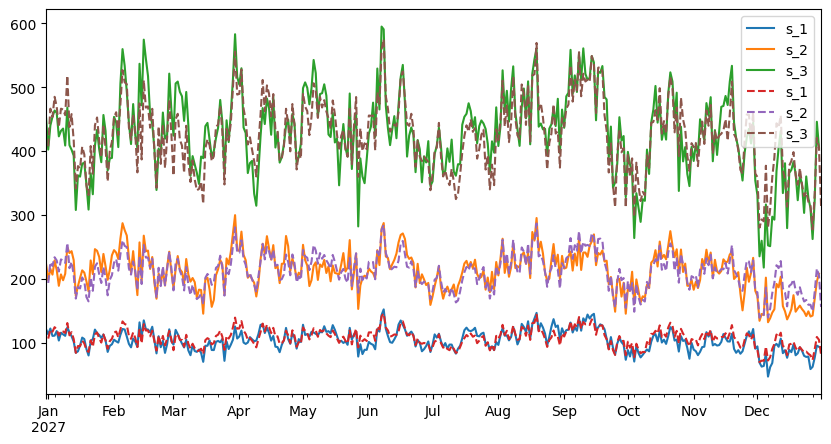

In [53]:
forecaster.plot_forecast()

In [50]:
from tsxp.explainers import ForecasterMsExogFeatureImportance
fi = ForecasterMsExogFeatureImportance(forecaster)


display(fi.feature_importance)
display(fi.feature_rank)
display(fi.relative_feature_importance)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18


100%|===================| 4366/4368 [01:01<00:00]        

PFI_MSE_TEST  TREE_SHAP_TEST  TREE_SHAP_TRAIN  \
weather                0.015784        0.072505         0.069779   
lag_1                  0.015414        0.069955         0.075390   
lag_2                  0.001232        0.019513         0.021327   
holiday                0.000156        0.007716         0.007647   
lag_3                  0.000017        0.002437         0.002491   
_level_skforecast      0.000011        0.001277         0.001212   
lag_4                 -0.000001        0.001068         0.001024   

                   TREE_PATH_SHAP  
weather                  0.069775  
lag_1                    0.077235  
lag_2                    0.021361  
holiday                  0.007475  
lag_3                    0.002523  
_level_skforecast        0.001278  
lag_4                    0.000996

Rank                                              
                  PFI_MSE_TEST TREE_SHAP_TEST TREE_SHAP_TRAIN TREE_PATH_SHAP
weather                      1              1               2              2
lag_1                        2              2               1              1
lag_2                        3              3               3              3
holiday                      4              4               4              4
lag_3                        5              5               5              5
_level_skforecast            6              6               6              6
lag_4                        7              7               7              7

Perc                                              
                  PFI_MSE_TEST TREE_SHAP_TEST TREE_SHAP_TRAIN TREE_PATH_SHAP
weather              48.397061      41.557234       39.010958      38.626033
lag_1                47.261274      40.095912       42.147850      42.755519
lag_2                 3.777152      11.183870       11.923372      11.824855
holiday               0.478961       4.422547        4.275152       4.138130
lag_3                 0.053475       1.396654        1.392406       1.396750
_level_skforecast     0.035160       0.731758        0.677576       0.707235
lag_4                -0.003082       0.612025        0.572685       0.551477

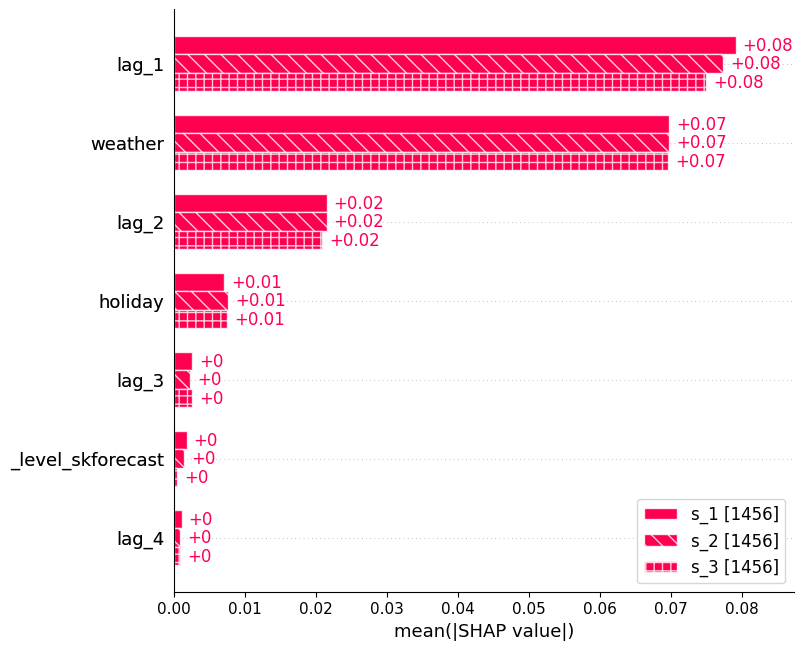

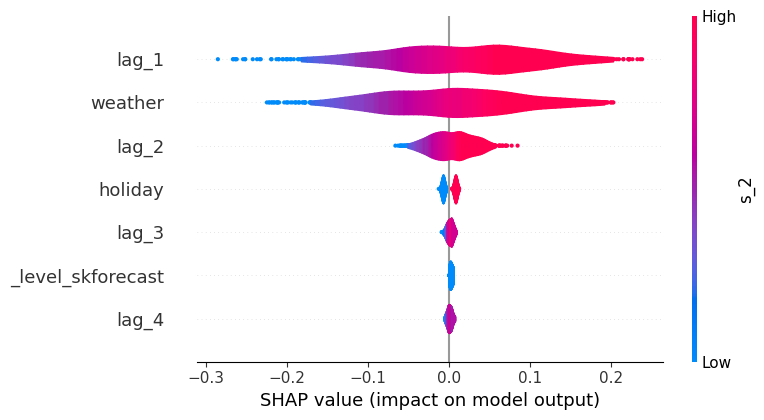

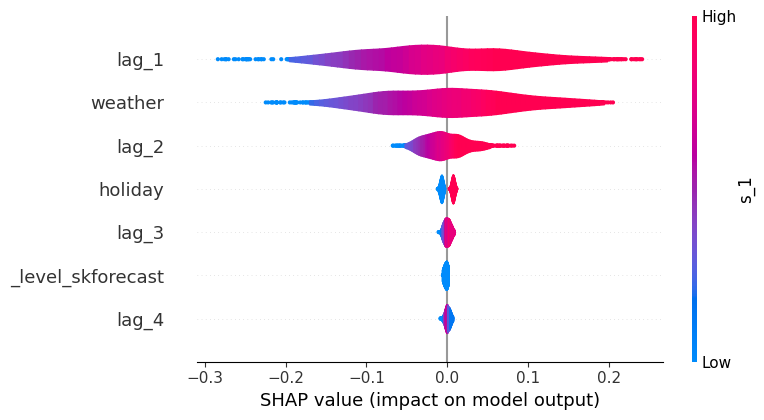

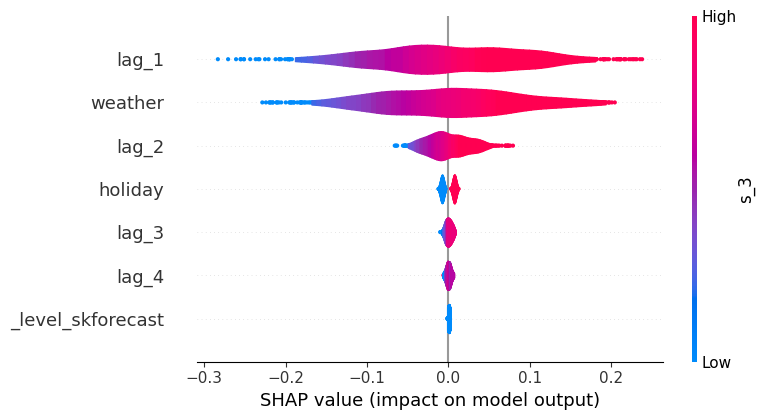

In [55]:
fi.plot_importance_for_series()

## Without scaling

Dataset dates      : (Timestamp('2023-01-01 00:00:00'), Timestamp('2027-12-30 00:00:00'))  (n=1825)
Train dates      : (Timestamp('2023-01-01 00:00:00'), Timestamp('2026-12-31 00:00:00'))  (n=1461)
Test dates      : (Timestamp('2026-12-31 00:00:00'), Timestamp('2027-12-30 00:00:00'))  (n=365)


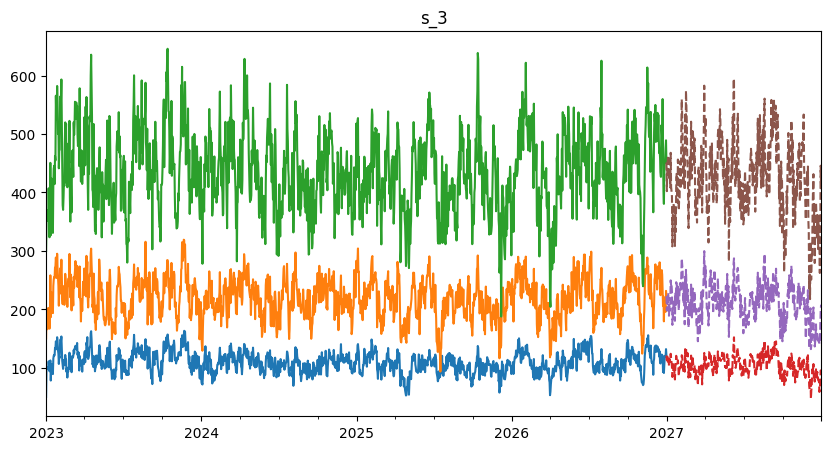

In [56]:
from tsxp.dataset import ForecasterMsDataset, DatasetMapping
from tsxp.forecaster import ForecasterMsExog
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection  import TimeSeriesFold

# define split date
split_date = "2026-12-31"

# df_exog["holiday"] = df_exog["holiday"].astype(bool) # SHAP has problems with bool

df_exog["holiday"] = df_exog["holiday"].astype(int) # bool is not supported by SHAP


mapping = DatasetMapping(
    freq="D",
    index="date",
    series_id="series_id",
    series_value="value",
)

dataset = ForecasterMsDataset(df_demand, df_exog, mapping, split_time=split_date)

dataset.show_sizes()
dataset.plot_series()


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 265.407917
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_chil

PFI_MSE_TEST  SHAP_TEST
lag_1              11682.337911  58.725770
_level_skforecast   4934.414833  54.456127
weather             1412.447769  19.557152
lag_2                430.450740   9.676216
holiday               18.703553   2.368767
lag_4                 10.463009   1.720124
lag_5                 10.003249   0.660491

Rank          
                  PFI_MSE_TEST SHAP_TEST
lag_1                        1         1
_level_skforecast            2         2
weather                      3         3
lag_2                        4         4
holiday                      5         5
lag_4                        6         6
lag_5                        7         7

Perc           
                  PFI_MSE_TEST  SHAP_TEST
lag_1                63.151797  39.904808
_level_skforecast    26.674212  37.003538
weather               7.635339  13.289301
lag_2                 2.326909   6.575096
holiday               0.101107   1.609603
lag_4                 0.056560   1.168843
lag_5                 0.054075   0.448811

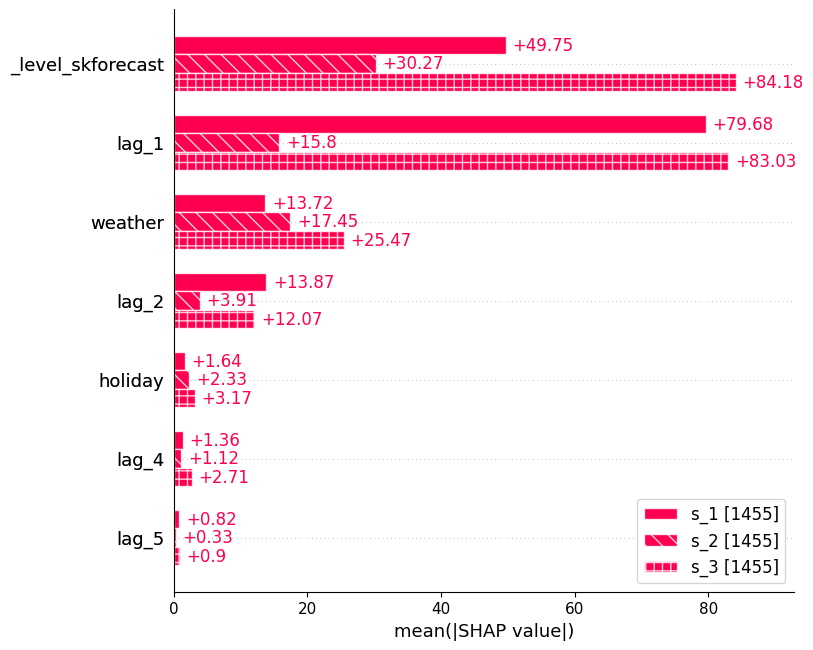

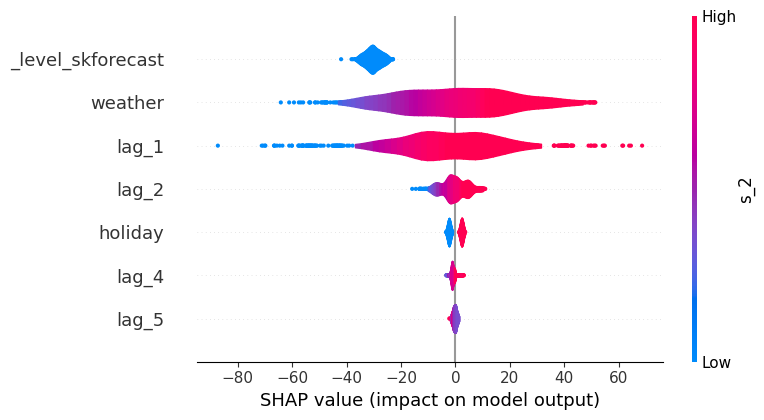

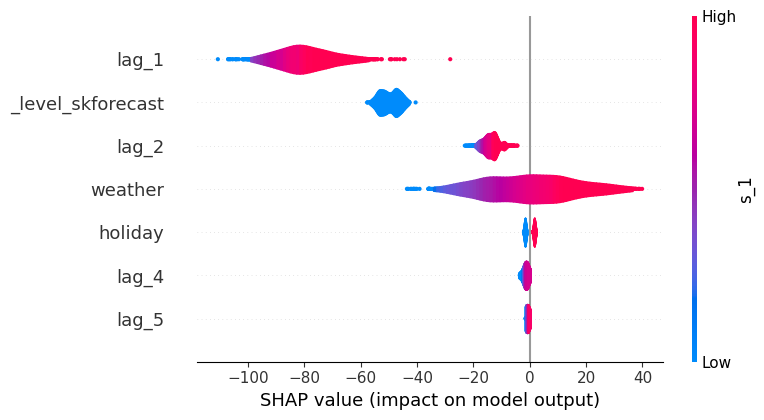

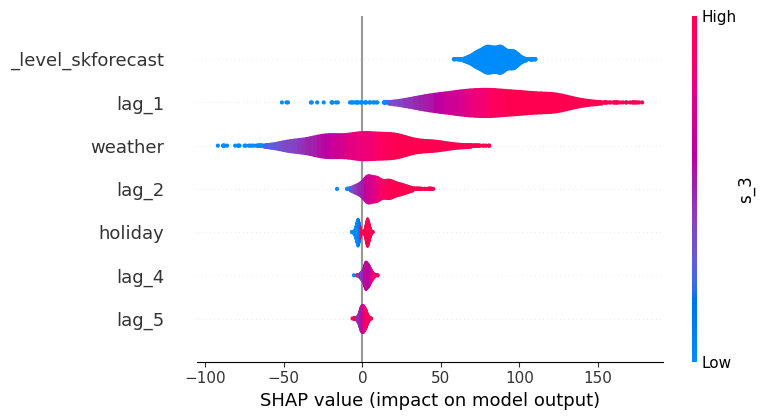

In [57]:
def search_space(trial):
    return {
        "lags": trial.suggest_categorical("lags", [ 4, [1, 2, 4, 5]]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
    }


regressor = LGBMRegressor()
print(regressor.get_params())

# scaler = MinMaxScaler()
scaler = None

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster = ForecasterMsExog( 
    data = dataset,
    regressor=regressor,
    scale=scaler
    # search_space=search_space,
)

forecaster.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  

fi = ForecasterMsExogFeatureImportance(forecaster)


display(fi.feature_importance)
display(fi.feature_rank)
display(fi.relative_feature_importance)




In [ ]:
fi.plot_importance_for_series()

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


## Different contributions

C:\Users\Matty\AppData\Local\Temp\ipykernel_57708\232093518.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_exog = pd.concat([df_exog, df_exog_brand])


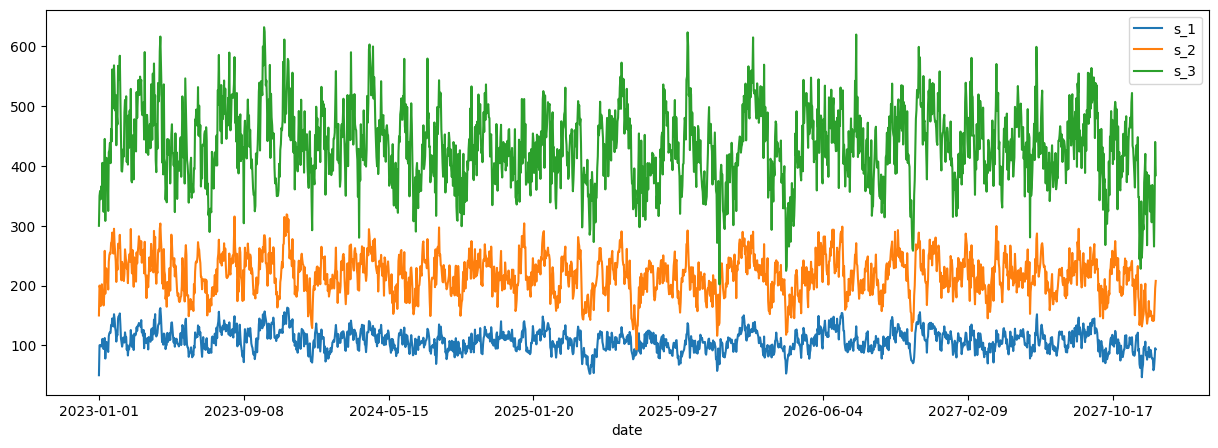

In [3]:
import pandas as pd

df = pd.read_csv("data/linear_dep_different_factors.csv")
series = ["s_1", "s_2", "s_3"]
df.set_index("date")[series].plot(figsize=(15, 5))
df.head()

df["date"] = pd.to_datetime(df["date"])
df["holiday"] = df["holiday"].astype(bool)

# df.info()

# melt the series and prepare for the model

df_demand = df.melt(
    id_vars=["date"], value_vars=series, var_name="series_id", value_name="value"
)

# create exog dataframe for holiday and	weather
df_exog_temp = df[["date", "holiday", "weather"]].drop_duplicates()

#replicate the exog data for each series and set the series_id
df_exog = pd.DataFrame(columns=df_exog_temp.columns)
df_exog["series_id"] = ""
for brand in series:
    df_exog_brand = df_exog_temp.copy()
    df_exog_brand["series_id"] = brand
    df_exog = pd.concat([df_exog, df_exog_brand])


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 265.316401
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_chil

PFI_MSE_TEST  SHAP_TEST
lag_1               8887.211527  55.372313
_level_skforecast   5132.080675  54.935215
weather             1423.345728  19.459552
lag_2               1119.743064  15.309109
holiday               18.117325   2.377205
lag_5                  9.756481   0.859726
lag_4                  2.377621   0.833929

Rank          
                  PFI_MSE_TEST SHAP_TEST
lag_1                        1         1
_level_skforecast            2         2
weather                      3         3
lag_2                        4         4
holiday                      5         5
lag_5                        6         6
lag_4                        7         7

Perc           
                  PFI_MSE_TEST  SHAP_TEST
lag_1                53.561191  37.125986
_level_skforecast    30.929876  36.832921
weather               8.578179  13.047226
lag_2                 6.748435  10.264440
holiday               0.109189   1.593866
lag_5                 0.058800   0.576429
lag_4                 0.014329   0.559132

100%|===================| 4355/4365 [01:47<00:00]        

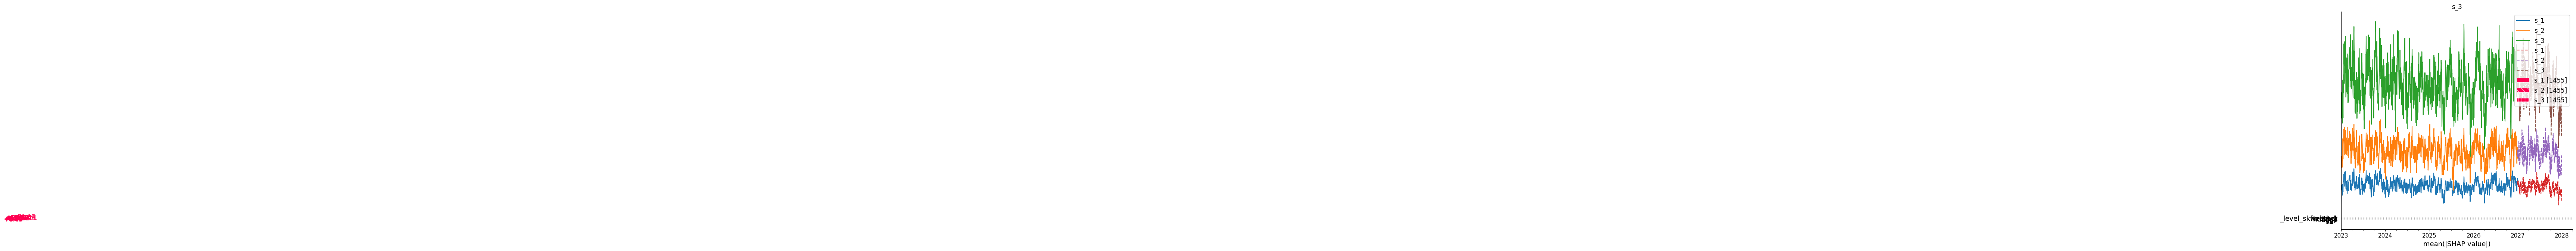

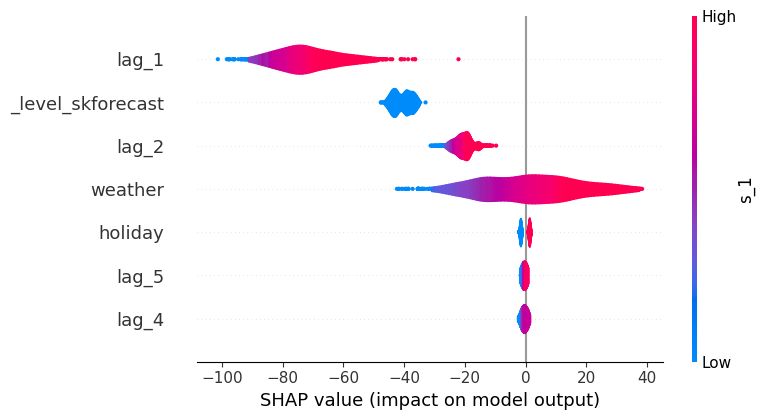

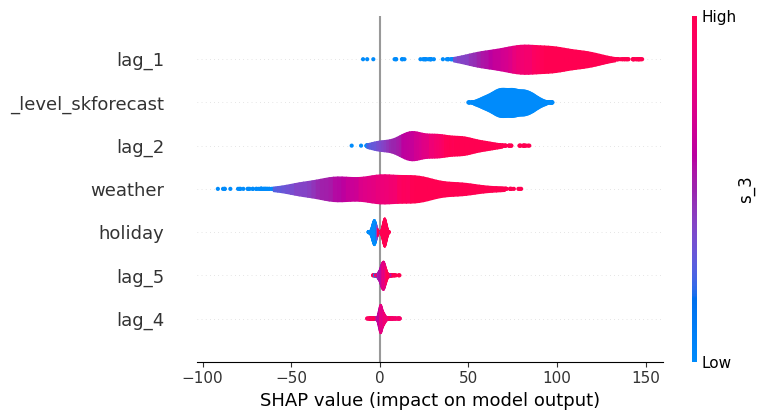

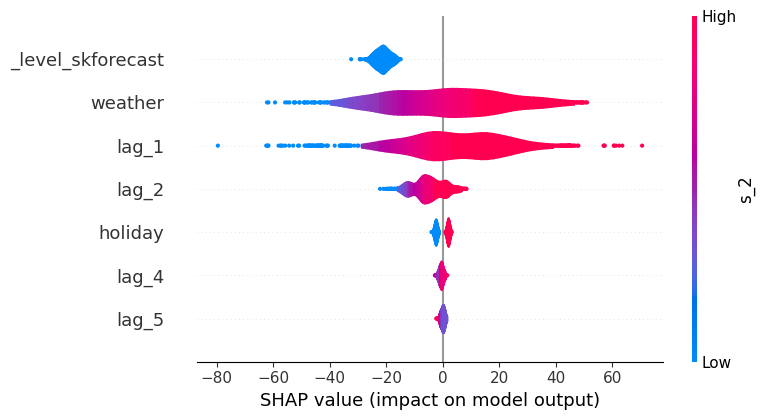

<Figure size 640x480 with 0 Axes>

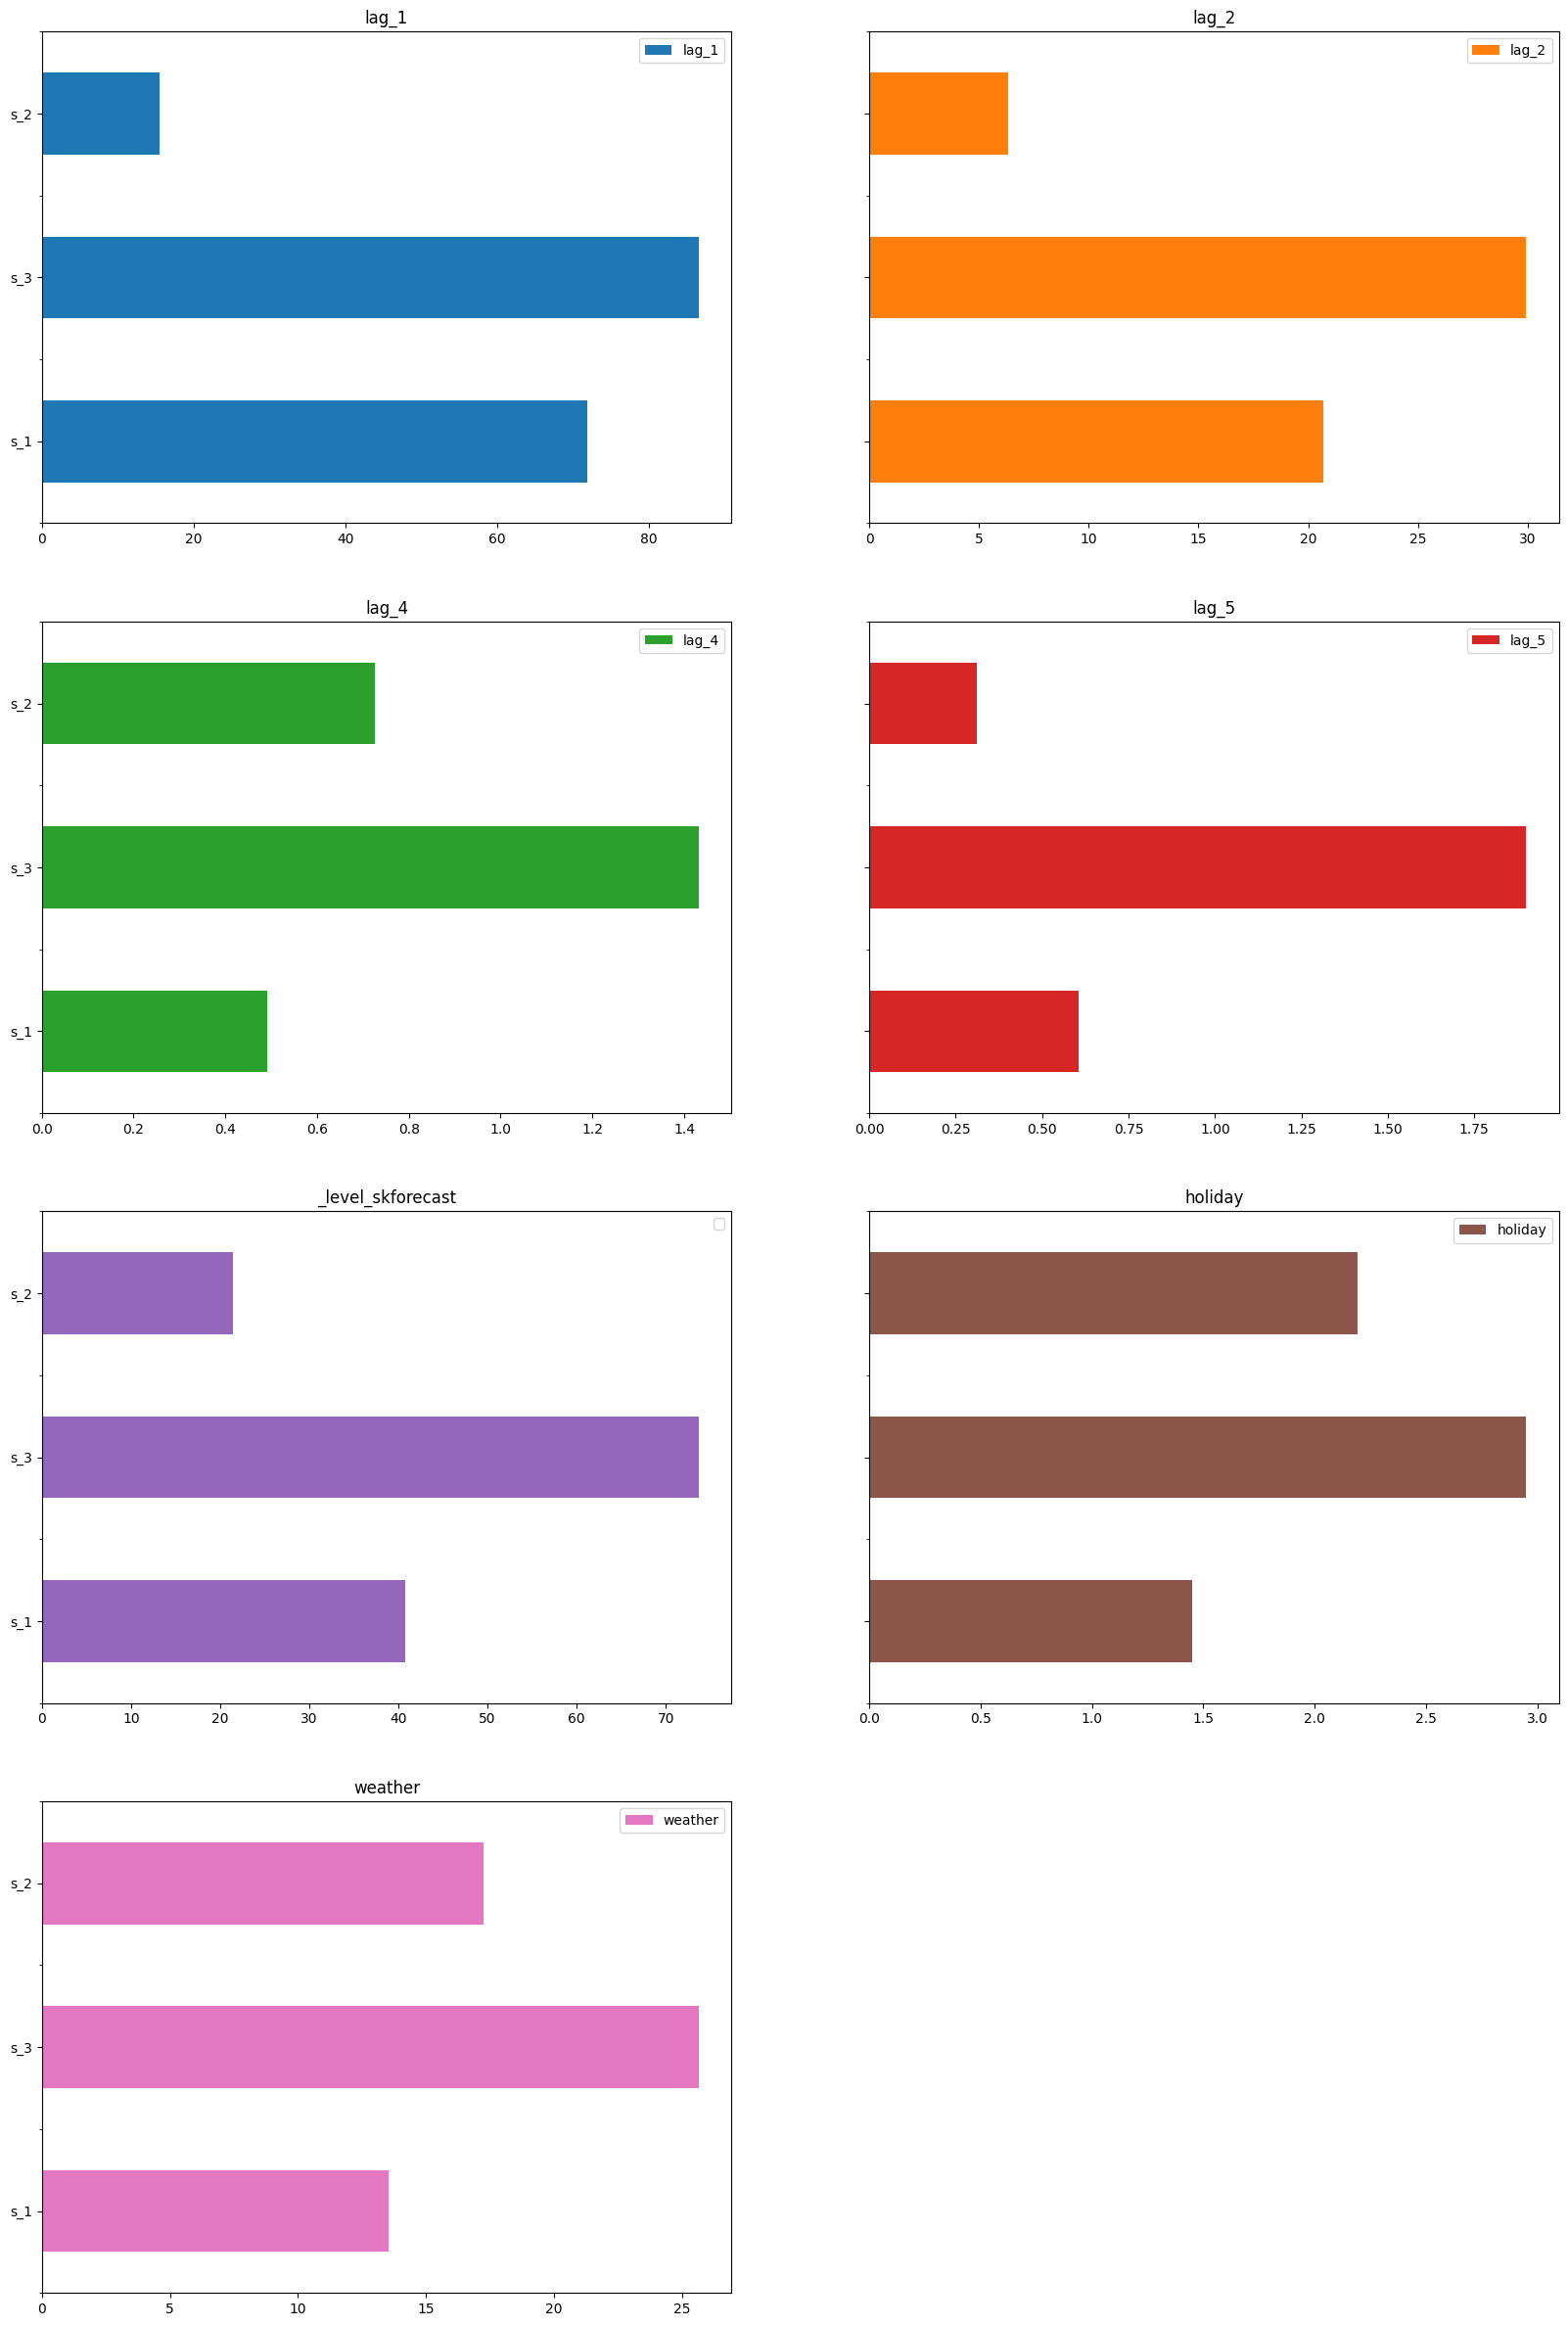

In [21]:
from tsxp.dataset import ForecasterMsDataset, DatasetMapping
from tsxp.forecaster import ForecasterMsExog
from tsxp.explainers import ForecasterMsExogFeatureImportance
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection  import TimeSeriesFold

# define split date
split_date = "2026-12-31"

# df_exog["holiday"] = df_exog["holiday"].astype(bool) # SHAP has problems with bool

df_exog["holiday"] = df_exog["holiday"].astype(int) # bool is not supported by SHAP


mapping = DatasetMapping(
    freq="D",
    index="date",
    series_id="series_id",
    series_value="value",
)

dataset = ForecasterMsDataset(df_demand, df_exog, mapping, split_time=split_date)
# dataset.show_sizes()
dataset.plot_series()

def search_space(trial):
    return {
        "lags": trial.suggest_categorical("lags", [ 4, [1, 2, 4, 5]]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
    }


regressor = LGBMRegressor()
print(regressor.get_params())

scaler = MinMaxScaler()
scaler = None

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster = ForecasterMsExog( 
    data = dataset,
    regressor=regressor,
    scale=scaler
    # search_space=search_space,
)

forecaster.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  

fi = ForecasterMsExogFeatureImportance(forecaster)


display(fi.feature_importance)
display(fi.feature_rank)
display(fi.relative_feature_importance)

fi.plot_importance_for_series()

### Grouped PFI 
https://github.com/thec0dewriter/grouped_permutation_importance
https://ebooks.iospress.nl/volumearticle/59564

Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', '_level_skforecast', 'holiday',
       'weather'],
      dtype='object')
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18


C:\Users\Matty\AppData\Local\Temp\ipykernel_57708\825148612.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax[0].boxplot(r.importances[sorted_idx].T,


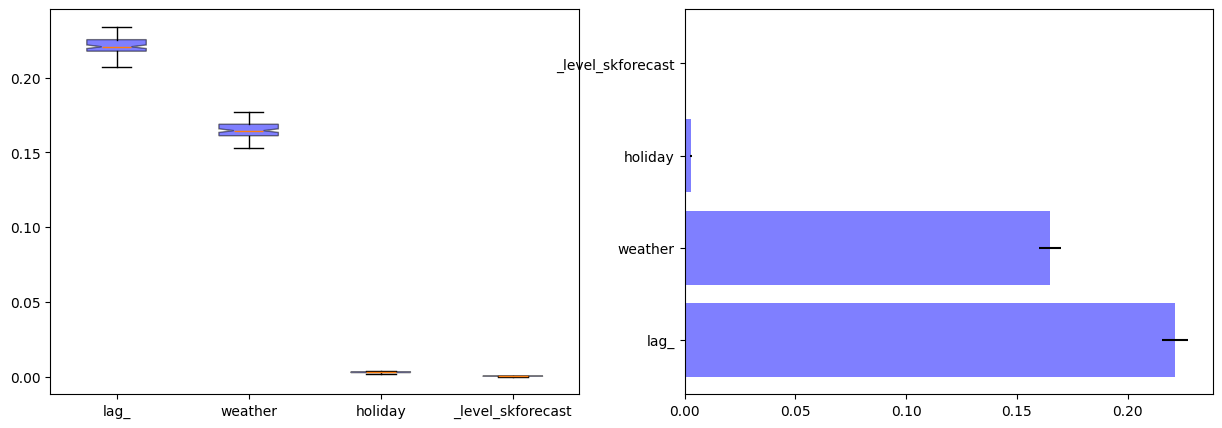

In [46]:


from grouped_permutation_importance import grouped_permutation_importance
import numpy as np

columns = ["lag_", "_level_skforecast", "holiday", "weather"]
idxs = []

(X_train, y_train, X_test, y_test) = forecaster.create_train_xy()
cols = X_train.columns
print(cols)

for key in columns:
    idxs.append([x for (x, y) in enumerate(cols) if key in y])

# idxs

r = grouped_permutation_importance(
            forecaster.forecaster.regressor,
            scoring="neg_mean_absolute_percentage_error",
            X=X_test.to_numpy(),
            y=y_test.to_numpy(),
            idxs= idxs, #self.data.series_dict_train,
            n_repeats=100,
            random_state=42,
            n_jobs=-1,
        )
sorted_idx = r.importances_mean.argsort()[::-1]

import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1,2 ,figsize=(15, 5))
 
box = ax[0].boxplot(r.importances[sorted_idx].T,
                    patch_artist=True,
                    showfliers=False, notch=True,
                    vert=True, labels=np.array(columns)[sorted_idx])
for patch in box['boxes']:
    patch.set_facecolor("blue")
    patch.set_alpha(.5)

# bar plot
bar = ax[1].barh(np.array(columns)[sorted_idx], r.importances_mean[sorted_idx], xerr=r.importances_std[sorted_idx], color="blue", alpha=0.5)


In [26]:
forecaster.forecaster.regressor.feature_importances_

array([5405, 4678, 3176, 2976,  200, 1212, 7629], dtype=int32)

## SHAP on full dataset vs on a series subset

Series id: s_1 - 0


 96%|=================== | 1395/1456 [00:19<00:00]       

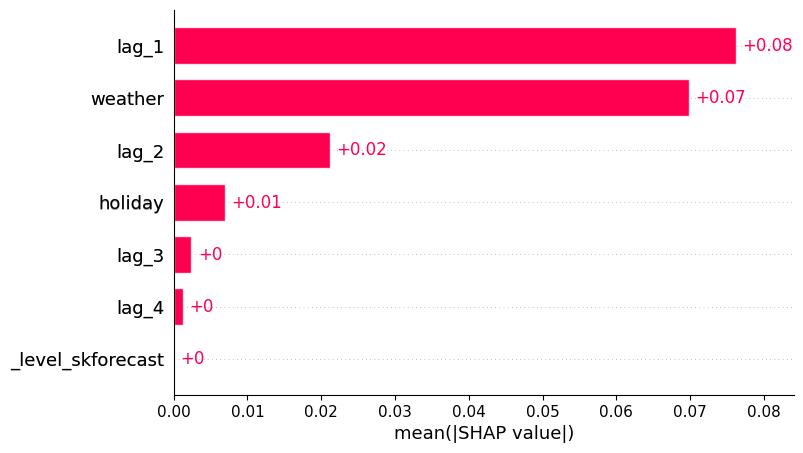

Series id: s_2 - 1


 99%|===================| 1444/1456 [00:20<00:00]        

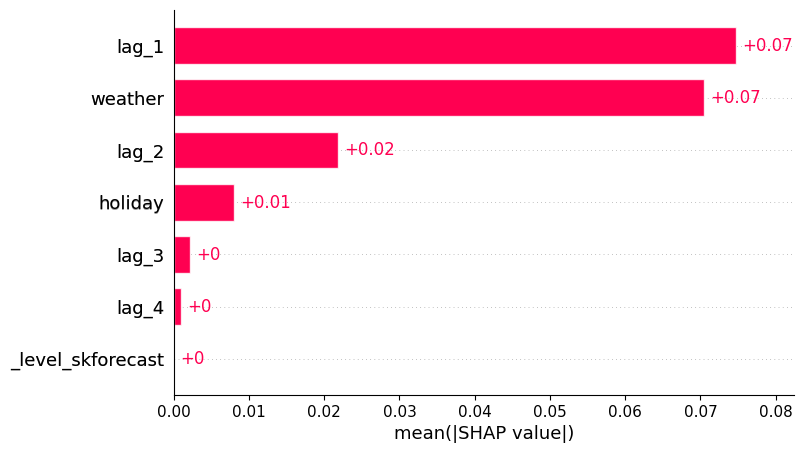

Series id: s_3 - 2


 99%|===================| 1442/1456 [00:20<00:00]        

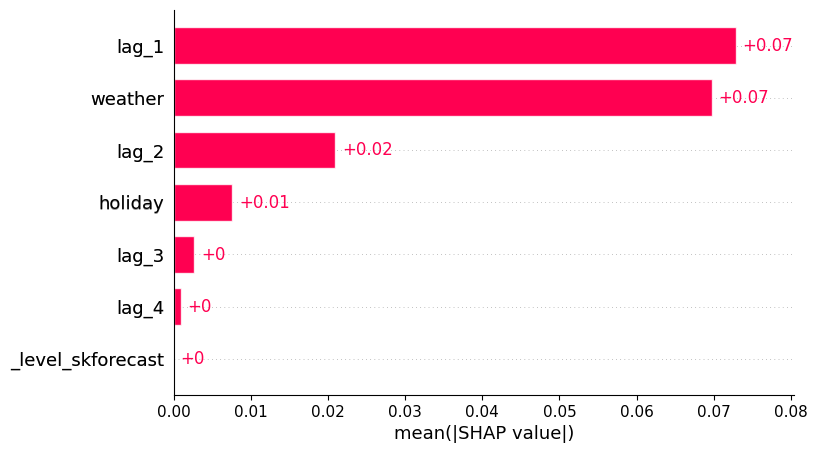

In [ ]:

fi.series_shap("s_1")
    
fi.series_shap("s_2")

fi.series_shap("s_3")

fi.plot_importance_for_series()

# fi.X_train